In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Load data
X = pd.read_csv('data/fingerprints.csv', index_col = 0)
df = pd.read_csv('data/p2x4_final.csv', index_col = 0)
Y = df['pIC50']
# Feature Selection
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [4]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=6)

In [5]:
# Hyperparameter grid for DecisionTreeRegressor
param_grid_dtr = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [6]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 4


In [7]:
# GridSearchCV for DecisionTreeRegressor
grid_search_dtr = GridSearchCV(estimator=DecisionTreeRegressor(random_state=6),
                               param_grid=param_grid_dtr, cv=5, n_jobs=N_CORES, verbose=2)
grid_search_dtr.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=6), n_jobs=4,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [8]:
# Selecting the best estimator from each GridSearchCV
best_model_dtr = grid_search_dtr.best_estimator_

# Step 1: Predict on Test Set

In [9]:
y_pred = best_model_dtr.predict(X_test)

# Step 2: Calculate Performance Metrics

Since this is a regression problem, you can use metrics such as Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and R-squared

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating the metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)


MSE: 0.2570666443887898
RMSE: 0.5070174004793029
MAE: 0.270637156063717
R2: 0.8550658447818572


# Step 3: Analyze Residuals

Analyzing the residuals (difference between the predicted and actual values) can provide insights into the behavior of your model

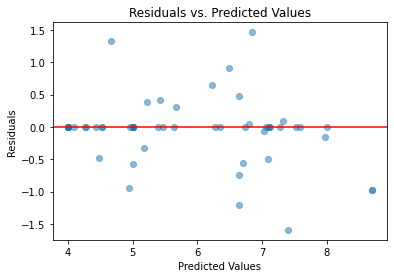

In [11]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [39]:
residuals.describe()

count    56.000000
mean     -0.053505
std       0.508749
min      -1.591621
25%       0.000000
50%       0.000000
75%       0.000000
max       1.463564
Name: pIC50, dtype: float64

# Step 4: Compare with Baseline 

It can be helpful to compare your model's performance against a simple baseline model, such as predicting the mean of the target variable for all instances. This gives you a reference point for how much your model has learned.

In [12]:
# Baseline predictions (mean of target variable)
baseline_preds = np.full_like(y_test, np.mean(y_train))

# Baseline Mean Squared Error
baseline_mse = mean_squared_error(y_test, baseline_preds)

print(f"Baseline Mean Squared Error: {baseline_mse}")
print(f"Model Mean Squared Error: {mse}")

Baseline Mean Squared Error: 1.795130876257679
Model Mean Squared Error: 0.2570666443887898


In [13]:
print(f"Best DecisionTreeRegressor: {grid_search_dtr.best_params_}")

Best DecisionTreeRegressor: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [14]:
maybridge_data = pd.read_csv("maybridge/Maybridge.csv")
maybridge_data

,SMILES,Code
0,Fc1ccc(C(c2ccc(F)cc2)N2CCNCC2)cc1,AC10018
1,CSc1nc(N)nc2nc[nH]c12,AC12157
2,CN(C)Cc1c[nH]c2ccc(OCc3ccccc3)cc12,AC13917
3,O=C(O)c1ccc(Br)o1,AC27191
4,NC(Cc1c[nH]c2ccc(Br)cc12)C(=O)O,AC29806
...,...,...
51768,CCO/C(C)=N/Oc1ccc([N+](=O)[O-])cc1[N+](=O)[O-],S14814
51769,O=C1c2ccccc2C(=O)N1Oc1ccc([N+](=O)[O-])c([N+](...,S14839
51770,O=[N+]([O-])c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1,S14896
51771,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1/C=C/c1ccccc1,SPB05721


In [15]:
descriptors = pd.read_csv('maybridge/out.csv', index_col = 0)
descriptors.shape

(51773, 881)

In [16]:
descriptors = selection.transform(descriptors)
descriptors.shape

(51773, 155)

In [17]:
# Apply the imputer to fill NaN values with the mean of each column
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
descriptors_imputed = imputer.fit_transform(descriptors)

In [18]:
# Step 3: Make Predictions
predicted_pic50 = best_model_dtr.predict(descriptors_imputed)

In [19]:
# Step 4: Analyze Results
# Append predictions to the Maybridge data
maybridge_data["predicted_pic50"] = predicted_pic50

In [20]:
maybridge_data

,SMILES,Code,predicted_pic50
0,Fc1ccc(C(c2ccc(F)cc2)N2CCNCC2)cc1,AC10018,4.000000
1,CSc1nc(N)nc2nc[nH]c12,AC12157,7.000000
2,CN(C)Cc1c[nH]c2ccc(OCc3ccccc3)cc12,AC13917,6.041914
3,O=C(O)c1ccc(Br)o1,AC27191,5.386158
4,NC(Cc1c[nH]c2ccc(Br)cc12)C(=O)O,AC29806,7.000000
...,...,...,...
51768,CCO/C(C)=N/Oc1ccc([N+](=O)[O-])cc1[N+](=O)[O-],S14814,4.522879
51769,O=C1c2ccccc2C(=O)N1Oc1ccc([N+](=O)[O-])c([N+](...,S14839,4.522879
51770,O=[N+]([O-])c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1,S14896,5.248721
51771,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1/C=C/c1ccccc1,SPB05721,4.860121


In [21]:
# Identify potent inhibitors
threshold = 6 # Define a threshold for pic50 values 
potent_inhibitors = maybridge_data[maybridge_data["predicted_pic50"] >= threshold]

In [22]:
potent_inhibitors

,SMILES,Code,predicted_pic50
1,CSc1nc(N)nc2nc[nH]c12,AC12157,7.000000
2,CN(C)Cc1c[nH]c2ccc(OCc3ccccc3)cc12,AC13917,6.041914
4,NC(Cc1c[nH]c2ccc(Br)cc12)C(=O)O,AC29806,7.000000
6,NC(Cc1c[nH]c2ccc(F)cc12)C(=O)O,AC42043,7.000000
9,COc1ccc2[nH]cc(CN(C)C)c2c1,AW00178,6.041914
...,...,...,...
51677,O=C1NC(=O)C(c2ccccc2)(C2CCC2)N1,BTB00337,7.000000
51711,CC(C)C(=O)Nc1ccc(-c2ccccc2)cc1,S14860,6.366532
51745,Cc1ccc(NCN2C(=O)c3ccccc3C2=O)c(C)c1,CC07101,6.187087
51746,CCc1ccc(NCN2C(=O)c3ccccc3C2=O)cc1,CD02026,6.187087


In [23]:
# Sort the potent_inhibitors DataFrame based on "predicted_pic50" in descending order
sorted_potent_inhibitors = potent_inhibitors.sort_values(by="predicted_pic50", ascending=False)
sorted_potent_inhibitors

,SMILES,Code,predicted_pic50
16871,N#Cc1c(Cl)cccc1Oc1ccc(S(=O)(=O)Nc2ccccc2C(=O)N...,JFD01405,8.698970
15449,CC(=O)Nc1cccc(OCCCNS(=O)(=O)c2ccc(Oc3cccc(Cl)c...,HTS03101,8.698970
10745,CS/C(=N/S(=O)(=O)c1ccccc1)NCc1c(Cl)cccc1Oc1ccccc1,CD06918,8.698970
37616,COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2...,RF05314,8.698970
16973,COc1ccc(Oc2cccc(Cl)c2CNC(=O)NS(=O)(=O)c2ccc(C)...,BTB09427,8.698970
...,...,...,...
25451,CC(C)(C)S(=O)(=O)/C(C#N)=C/Nc1ccc(Cl)cn1,KM09040,6.013228
26722,CS(=O)(=O)/C(C#N)=C/Nc1cnccn1,BTB11835,6.013228
25018,N#C/C(=C\NCc1cccnc1)S(=O)(=O)Cc1ccc(Cl)cc1,DSHS00522,6.013228
25327,CS(=O)(=O)/C(C#N)=C/Nc1cccnc1,HTS05113,6.013228


In [24]:
sorted_potent_inhibitors.predicted_pic50.describe()

count    7553.000000
mean        6.658494
std         0.404070
min         6.013228
25%         6.259637
50%         6.804100
75%         7.000000
max         8.698970
Name: predicted_pic50, dtype: float64

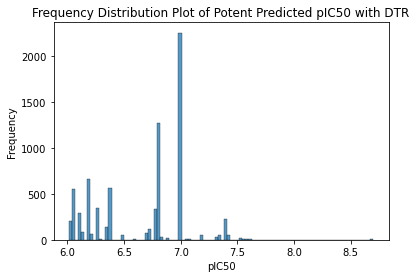

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=potent_inhibitors, x='predicted_pic50', kde=False, bins=100)

# Set the title and labels for the plot
plt.title('Frequency Distribution Plot of Potent Predicted pIC50 with DTR')
plt.xlabel('pIC50')
plt.ylabel('Frequency')


plt.savefig('figures/potent_predicted_dtr.png')
# Show the plot
plt.show()

In [26]:
# Save the potent inhibitors to a CSV file
potent_inhibitors.to_csv("maybridge/dtr_potent_p2x4_inhibitors.csv", index=False)

In [27]:
# 1. Load the common potent inhibitors
common_df = pd.read_csv("maybridge/common_potent_inhibitors.csv")
common_df

,smiles
0,O=C(Nc1ccccc1Cl)c1ccc(-c2ccccn2)s1
1,O=C(Nc1ccccc1Sc1nc2ccc(Cl)cc2s1)c1ccc(F)cc1
2,COC(=O)c1cccc(NC(=O)c2ccc(Cl)cc2)c1
3,N#Cc1ccc(-c2c(NC(=O)NS(=O)(=O)c3ccccc3Cl)oc(-c...
4,Cc1onc(-c2ccccc2)c1C(=O)Nc1ccc(C(F)(F)F)cc1Cl
...,...
383,Cc1cc(NS(=O)(=O)c2ccc(NC(=O)c3ccccc3Cl)cc2)no1
384,O=C(Nc1cccc(-c2nc3ccccc3[nH]2)c1)c1ccc(F)cc1
385,O=C(Nc1ccc(NC(=S)Nc2ccc(Cl)cc2)cc1)c1ccccc1O
386,Cc1c(CC(=O)Nc2ccc(Cl)cc2)sc2ccc(Cl)cc12


In [28]:
filtered_potent_inhibitors = potent_inhibitors[potent_inhibitors["SMILES"].isin(common_df["smiles"])]
filtered_potent_inhibitors

,SMILES,Code,predicted_pic50
66,O=C(Nc1ccc(-n2nccc2C(F)(F)F)cc1)c1ccc(Cl)cc1,AW00193,6.804100
110,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,EN00095,6.891469
250,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,AW00256,6.891469
650,CC(=O)Nc1cccc(OCCCNS(=O)(=O)c2ccc(N3C(=O)CC4(C...,AW00490,6.837466
758,O=C(NCCNS(=O)(=O)c1ccc(Cl)cc1)C1=Cc2cc(Cl)ccc2OC1,GK00081,6.837466
...,...,...,...
49720,Cc1onc(-c2ccc(Cl)cc2)c1-c1ccnc(SCC(=O)Nc2ccc(C...,S10227,6.886057
49780,Cc1cc(-c2nc(C)c(-c3nnc(SCC(=O)Nc4ccc(C(C)C)cc4...,S15050,6.886057
50705,CCOC(=O)c1cc2c(NC(=O)c3ccc(Cl)cc3)c(C(=O)OCC)s...,RJF02129,6.804100
51287,O=C(Cc1ccccc1)Nc1ccc(Cl)cc1,S13395,6.267606


In [29]:
filtered_potent_inhibitors.predicted_pic50.describe()

count    394.000000
mean       6.646199
std        0.457423
min        6.029188
25%        6.200659
50%        6.804100
75%        6.809668
max        8.698970
Name: predicted_pic50, dtype: float64

In [31]:
# 3. Sort the filtered data based on pic50 values in descending order (assuming higher is more potent)
sorted_common = filtered_potent_inhibitors.sort_values(by="predicted_pic50", ascending=False)
sorted_common

,SMILES,Code,predicted_pic50
37616,COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2...,RF05314,8.698970
16871,N#Cc1c(Cl)cccc1Oc1ccc(S(=O)(=O)Nc2ccccc2C(=O)N...,JFD01405,8.698970
15449,CC(=O)Nc1cccc(OCCCNS(=O)(=O)c2ccc(Oc3cccc(Cl)c...,HTS03101,8.698970
19281,Cc1cc(NS(=O)(=O)c2ccc(NC(=O)COc3ccc(Cl)cc3Cl)c...,BTB10526,7.585027
25805,Cc1onc(-c2c(Cl)cccc2Cl)c1NC(=O)N=S(C)(=O)c1ccc...,KM09094,7.568636
...,...,...,...
45968,CCN(CC)c1ccc(NC(=O)c2c(-c3c(Cl)cccc3Cl)noc2C)c...,S05695,6.029188
45862,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)Nc1ccc(Sc2ccccc2)...,RJC00553,6.029188
7952,Cc1onc(-c2ccccc2Cl)c1C(=O)Nc1cccnc1,CD05388,6.029188
34882,CC(=O)Nc1cccc(-c2cc(-c3ccc(Cl)cc3Cl)no2)c1,NRB01201,6.029188


In [37]:
# Save the potent inhibitors to a CSV file
sorted_common.to_csv("maybridge/dtr_sorted_common.csv", index=False)

In [32]:
best_model_dtr

DecisionTreeRegressor(max_depth=20, max_features='log2', random_state=6)

In [35]:
top20 = sorted_common.sort_values(by="predicted_pic50", ascending=False).head(20)
top20

,SMILES,Code,predicted_pic50
37616,COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2...,RF05314,8.698970
15449,CC(=O)Nc1cccc(OCCCNS(=O)(=O)c2ccc(Oc3cccc(Cl)c...,HTS03101,8.698970
16871,N#Cc1c(Cl)cccc1Oc1ccc(S(=O)(=O)Nc2ccccc2C(=O)N...,JFD01405,8.698970
19281,Cc1cc(NS(=O)(=O)c2ccc(NC(=O)COc3ccc(Cl)cc3Cl)c...,BTB10526,7.585027
25805,Cc1onc(-c2c(Cl)cccc2Cl)c1NC(=O)N=S(C)(=O)c1ccc...,KM09094,7.568636
25804,Cc1onc(-c2c(Cl)cccc2Cl)c1NC(=O)N=S(C)(=O)c1ccccc1,KM09189,7.568636
13559,Cc1cc(NS(=O)(=O)c2ccc(NC(=O)c3c(-c4ccccc4Cl)no...,BTB07672,7.522879
25780,CCCS(=O)(=O)c1cscc1NC(=O)c1c(-c2ccccc2Cl)noc1C,KM09142,7.522879
25781,CCCS(=O)(=O)c1cscc1NC(=O)c1c(-c2c(F)cccc2Cl)noc1C,KM09152,7.522879
22204,NS(=O)(=O)c1ccc(NC(=O)CSc2nnc(-c3ccc(Cl)cc3)o2...,HTS04304,7.522879


In [36]:
top20.to_csv("maybridge/dtr_top20.csv", index=False)

In [33]:
# Let's suppose df['pIC50'] is your target variable
print(df['pIC50'].nunique())
print(df['pIC50'].value_counts())

207
4.000000    70
5.000000    69
4.522879    14
6.494850     5
7.408935     5
            ..
6.767004     1
6.804100     1
7.397940     1
5.248721     1
5.894831     1
Name: pIC50, Length: 207, dtype: int64


In [34]:
# Model Evaluation for RandomForestRegressor
y_test_pred_rf = best_model_rf.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

NameError: name 'best_model_rf' is not defined

In [ ]:
# Printing the results
print(f"RandomForestRegressor - Test Mean Squared Error: {mse_test_rf}")
print(f"Best RandomForestRegressor: {grid_search_rf.best_params_}")